In [1]:
import os
import urllib.request

output_dir = "../../LCMS/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/LCMS/SUB12877/1096.SUB12877_lipidXData.csv', 
'https://storage.googleapis.com/abca7lof/LCMS/SUB12877/3497.SUB12877_LipidomicsData.xlsx']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!
Download completed!


In [405]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text

In [406]:
# Load data 

# Load the Excel file
excel_file = os.path.join(output_dir, '3497.SUB12877_LipidomicsData.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'All lipids'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)

In [407]:
dictionary = {'s1': 'Control, No Treatment', 
              's2': 'ABCA7 LoF (p.Glu50fs*3), No Treatment', 
              's3': 'Control, H₂O', 
              's4': 'ABCA7 LoF (p.Glu50fs*3), H₂O', 
              's5': 'ABCA7 LoF (p.Glu50fs*3), Choline'}

In [408]:
# get the normalized areas
areas = data.iloc[3:,11:26]
areas.columns = areas.iloc[0]
norm_areas = areas[1:]
norm_areas.index = np.arange(len(norm_areas))
sample_names = np.array([dictionary[x.split('[')[1].split('-')[0]] for x in norm_areas.columns])
norm_areas_subset = norm_areas.loc[:,sample_names!='ABCA7 LoF (p.Glu50fs*3), Choline']
sample_names_subset = sample_names[sample_names!='ABCA7 LoF (p.Glu50fs*3), Choline']
lipid_names = data.iloc[3:,:5]
lipid_names.columns = lipid_names.iloc[0]
lipid_names = lipid_names[1:]

Text(0, 0.5, 'PC 2 (17.14%)')

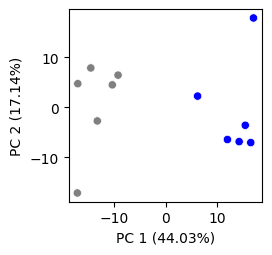

In [85]:
# perform PCA - with removing batch effects
scaler = StandardScaler()

x = scaler.fit_transform(norm_areas_subset.iloc[:,:6].T)
y = scaler.fit_transform(norm_areas_subset.iloc[:,6:].T)
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(np.vstack((x,y)))#scaler.fit_transform(norm_areas_subset.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = sample_names_subset

# plot the data
plt.figure(figsize=(2.5, 2.5))
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette={'Control, No Treatment': 'grey', 'Control, H₂O': 'grey', 'ABCA7 LoF (p.Glu50fs*3), No Treatment': 'blue', 'ABCA7 LoF (p.Glu50fs*3), H₂O': 'blue'}, edgecolor='w')
plt.legend([],[], frameon=False)


explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')

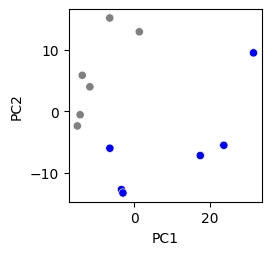

In [88]:
# perform PCA - without removing batch effects
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(norm_areas_subset.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = sample_names_subset

# plot the data
plt.figure(figsize=(2.5, 2.5))
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette={'Control, No Treatment': 'grey', 'Control, H₂O': 'grey', 'ABCA7 LoF (p.Glu50fs*3), No Treatment': 'blue', 'ABCA7 LoF (p.Glu50fs*3), H₂O': 'blue'}, edgecolor='w')
plt.legend([],[], frameon=False)


In [409]:
principal_components['condition_major'] = [x.split(' ')[0] for x in principal_components['condition'].values]

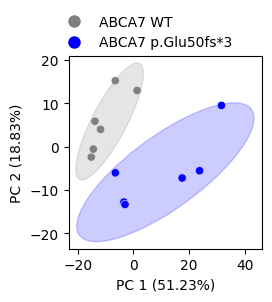

In [410]:
# plot the data
plt.figure(figsize=(2.5, 2.5))
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette={'Control, No Treatment': 'grey', 'Control, H₂O': 'grey', 'ABCA7 LoF (p.Glu50fs*3), No Treatment': 'blue', 'ABCA7 LoF (p.Glu50fs*3), H₂O': 'blue'}, edgecolor='w')

for treatment in principal_components['condition_major'].unique():
    line_data = principal_components[principal_components['condition_major'] == treatment]
    confidence_ellipse = np.cov(line_data['PC1'], line_data['PC2'])
    eigenvals, eigenvecs = np.linalg.eig(confidence_ellipse)
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))   
    ellipse = patches.Ellipse(xy=(line_data['PC1'].mean()+1.5, line_data['PC2'].mean()),
                                width=1.95*np.sqrt(eigenvals[0])*2,
                                height=1.9*np.sqrt(eigenvals[1])*2,
                                angle=angle,
                                fill=True,
                                alpha=0.2,
                                color='blue' if treatment=='ABCA7' else 'grey')
    
    plt.gca().add_patch(ellipse)

explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Glu50fs*3')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
#plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)
# plt.xlim(-13,10)
# plt.ylim(-11,13)
plt.savefig('../../paper/main_plots/g2_pca_lipids.png', dpi=300, bbox_inches='tight')
plt.show()

In [411]:
names = np.array(principal_components['condition_major'])
lipid_names.index = np.arange(len(lipid_names))
index = np.sum(norm_areas_subset==0, axis=1)<6
norm_areas_subset = norm_areas_subset[index]
lipid_names = lipid_names[index] 

In [412]:
all_pvalues = []
all_logfc = []
for i in range(norm_areas_subset.shape[0]):
    current_row = norm_areas_subset.iloc[i]
    control_values = current_row[names=='Control,'].values
    lof_values = current_row[names=='ABCA7'].values
    t_stat, p_value = ttest_ind(control_values.astype(float), lof_values.astype(float), equal_var=True, alternative='two-sided')
    logfc = np.log2(np.mean(lof_values)/np.mean(control_values))
    all_pvalues.append(p_value)
    all_logfc.append(logfc)

In [413]:
lipid_names['p_value'] = all_pvalues
lipid_names['log2_fold_change'] = all_logfc
_, fdr_corrected_pvals, _, _ = smm.multipletests(lipid_names['p_value'], alpha=0.05, method='fdr_bh')
lipid_names['FDR'] = fdr_corrected_pvals

In [414]:
lipid_names['score'] = np.sign(lipid_names['log2_fold_change'])*(-np.log10(lipid_names['FDR']))

In [415]:
lipid_names.index = lipid_names['name']

In [417]:
# Lipid categories
palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids': '#F9C31F', 
    'other': '#F97A1F'
}

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/2774269088.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[temp['FDR']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/2774269088.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

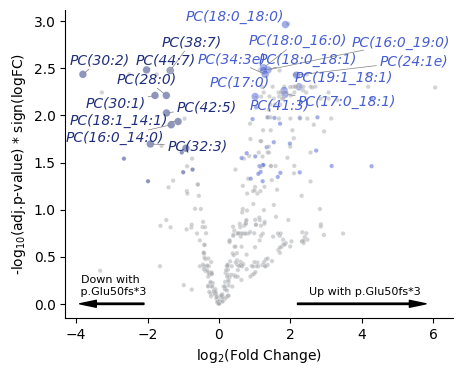

In [696]:
plt.figure(figsize=(5, 4))

temp = lipid_names#[ (lipid_names['key']=='PC')]

# all lipids that are not significant are set to 'other'
temp[temp['FDR']>0.05]['cat'] = 'other'

# select the top 10 and bottom 10 PCs by score
temp2 = lipid_names[ (lipid_names['key']=='PC')]
bottom_genes = temp2.nsmallest(10, 'score')['name']
top_genes = temp2.nlargest(10, 'score')['name']
top_genes = np.concatenate([bottom_genes, top_genes])

# Set all names that are not in the top 10 and bottom 10 to 'other'
temp.loc[~temp['name'].isin(top_genes), 'cat'] = 'other'

# Set the size of the points to small if they are not in the top 10 and bottom 10
temp['size'] = np.where(temp['name'].isin(top_genes), 50, 10)

# assign categories based on significance
temp['cat'][(temp['log2_fold_change']<0) & (temp['FDR']<0.05)] = 'down'
temp['cat'][(temp['log2_fold_change']>0) & (temp['FDR']<0.05)] = 'up'
temp['cat'][temp['key']!='PC']='other'

# all lipids that are not PC are set to 'other'

palette = {'down': '#1F2E7A', 'up': '#475ED1', 'other': '#A7A9AC'}


sns.scatterplot(data=temp, x='log2_fold_change', y=-1*np.log10(temp['FDR']), hue='cat', size='size', sizes=(10, 30), palette=palette, alpha=0.5)

# Label top genes
texts = []
for gene in top_genes:
    
    if (temp.loc[gene, 'FDR'] < 0.05) & (np.abs(temp.loc[gene, 'log2_fold_change']) > 1):
        #print(gene)
        color = palette[temp.loc[gene, 'cat']]
        txt = plt.text(temp.loc[gene, 'log2_fold_change'],
                       -1 * np.log10(temp.loc[gene, 'FDR']),
                       gene.split('+')[0], fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(6,0), xytext=(2, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(4.1, .1, 'Up with p.Glu50fs*3', ha='center', fontsize=8)

plt.annotate('', xy=(-4,0), xytext=(-2, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-3, .1, 'Down with \n p.Glu50fs*3', ha='center', fontsize=8)

plt.legend().remove()
plt.title('', fontsize=10)



plt.savefig('../../paper/main_plots/pcs_volcano.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1279261403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[temp['FDR']>0.05]['cat'] = 'other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1279261403.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

3 [-0.48114657  0.9396774 ]
5 [0.21986004 0.3023652 ]


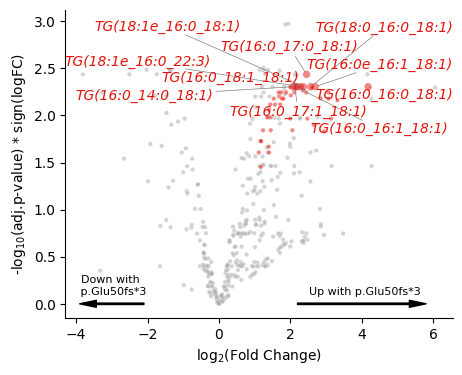

In [690]:
plt.figure(figsize=(5, 4))

temp = lipid_names#[ (lipid_names['key']=='PC')]

# all lipids that are not significant are set to 'other'
temp[temp['FDR']>0.05]['cat'] = 'other'

# select the top 10 and bottom 10 PCs by score
temp2 = lipid_names[ (lipid_names['key']=='TG')]
bottom_genes = temp2.nsmallest(0, 'score')['name']
top_genes = temp2.nlargest(10, 'score')['name']
top_genes = np.concatenate([bottom_genes, top_genes])

# Set all names that are not in the top 10 and bottom 10 to 'other'
temp.loc[~temp['name'].isin(top_genes), 'cat'] = 'other'

# Set the size of the points to small if they are not in the top 10 and bottom 10
temp['size'] = np.where(temp['name'].isin(top_genes), 50, 10)

# assign categories based on significance
temp['cat'][(temp['log2_fold_change']<0) & (temp['FDR']<0.05)] = 'down'
temp['cat'][(temp['log2_fold_change']>0) & (temp['FDR']<0.05)] = 'up'
temp['cat'][temp['FDR']>0.05] = 'other'

# all lipids that are not PC are set to 'other'
temp['cat'][temp['key']!='TG']='other'

palette = {'down': '#F6423C', 'up': '#E3120B', 'other': '#A7A9AC'}


sns.scatterplot(data=temp, x='log2_fold_change', y=-1*np.log10(temp['FDR']), hue='cat', size='size', sizes=(10, 30), palette=palette, alpha=0.5)

# Label top genes
texts = []
for gene in top_genes:
    
    if (temp.loc[gene, 'FDR'] < 0.05) & (np.abs(temp.loc[gene, 'log2_fold_change']) > 1):
        #print(gene)
        color = palette[temp.loc[gene, 'cat']]
        txt = plt.text(temp.loc[gene, 'log2_fold_change'],
                       -1 * np.log10(temp.loc[gene, 'FDR']),
                       gene.split('+')[0], fontsize=10, ha='right', va='bottom', style='italic', color=color)
        texts.append(txt)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(6,0), xytext=(2, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(4.1, .1, 'Up with p.Glu50fs*3', ha='center', fontsize=8)

plt.annotate('', xy=(-4,0), xytext=(-2, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-3, .1, 'Down with \n p.Glu50fs*3', ha='center', fontsize=8)

plt.legend().remove()
plt.title('', fontsize=10)



plt.savefig('../../paper/main_plots/tgs_volcano.png', dpi=300, bbox_inches='tight')
plt.show()


In [687]:
temp['cat'][temp['key']!='TG']='other'

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/2229544721.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp['cat'][temp['key']!='TG']='other'
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/222954472

In [688]:
temp[temp['key']!='TG']

3,name,lipidion,key,Class,Subclass,p_value,log2_fold_change,FDR,score,direction,size,cat
name,,,,,,,,,,,,
Cer(d15:0_26:2)-H_47.3,Cer(d15:0_26:2)-H_47.3,Cer(d15:0_26:2)-H,Cer,Sphingolipids,Ceramides,0.096634,-0.612545,0.179414,-0.746145,other,10,other
Cer(d17:1_16:0)-H_42.85,Cer(d17:1_16:0)-H_42.85,Cer(d17:1_16:0)-H,Cer,Sphingolipids,Ceramides,0.524185,-0.242076,0.603607,-0.219246,other,10,other
Cer(d18:0_16:0)+H_35.41,Cer(d18:0_16:0)+H_35.41,Cer(d18:0_16:0)+H,Cer,Sphingolipids,Ceramides,0.407819,0.256591,0.492112,0.307936,other,10,other
Cer(d18:0_18:0)+H_44.03,Cer(d18:0_18:0)+H_44.03,Cer(d18:0_18:0)+H,Cer,Sphingolipids,Ceramides,0.010575,2.109618,0.034345,1.464135,up,10,other
Cer(d18:0_18:0)-H_45.32,Cer(d18:0_18:0)-H_45.32,Cer(d18:0_18:0)-H,Cer,Sphingolipids,Ceramides,0.016795,0.817624,0.046993,1.327963,other,10,other
...,...,...,...,...,...,...,...,...,...,...,...,...
WE(44:4)-H_49.06,WE(44:4)-H_49.06,WE(44:4)-H,WE,Fatty acyl and other lipids,wax esters,0.910982,0.091287,0.940688,0.026554,other,10,other
ZyE()+H-H2O_37.51,ZyE()+H-H2O_37.51,ZyE()+H-H2O,ZyE,Neutral lipids,Zymosterol Ester,0.057955,1.943893,0.129049,0.889245,other,10,other
ZyE(20:3)+H_52.77,ZyE(20:3)+H_52.77,ZyE(20:3)+H,ZyE,Neutral lipids,Zymosterol Ester,0.025413,1.159907,0.063680,1.195994,other,10,other


In [445]:
import re

def sum_double_bonds(lipid_str):
    """
    Given a lipid species string like "PC(16:0_18:1)+Na",
    extract the fatty acid parts, then sum the number after ':' for each.
    """
    # Use regex to extract the content within parentheses.
    match = re.search(r'\((.*?)\)', lipid_str)
    if match:
        # Get the fatty acids inside the parentheses.
        fatty_acids = match.group(1)
        # Split the fatty acids by underscore.
        acids = fatty_acids.split('_')
        total = 0
        for acid in acids:
            # Each acid is in the form "XX:Y" (and might have extra characters sometimes)
            parts = acid.split(':')
            if len(parts) == 2:
                try:
                    # Remove any non-digit characters from the second part and convert to int.
                    bonds = int(re.sub(r'\D', '', parts[1]))
                    total += bonds
                except ValueError:
                    pass
        return total
    return None

# Example usage:
lipid_list = ['PC(15:0_16:0)+Na', 'PC(16:0_16:1)+Na', 'PC(16:0)+Na', 'PC(16:2_16:1_15:3)+Na', 'PC(16:0_18:1)+Na']
for lipid in lipid_list:
    print(lipid, sum_double_bonds(lipid))


import re

def sum_total_carbons(lipid_str):
    """
    Given a lipid species string like "PC(15:0_16:0)+Na",
    extract the fatty acid parts and sum the number before ':' (the carbon number)
    for each fatty acid.
    """
    # Extract the part within parentheses
    match = re.search(r'\((.*?)\)', lipid_str)
    if match:
        fatty_acids = match.group(1)
        acids = fatty_acids.split('_')
        total = 0
        for acid in acids:
            parts = acid.split(':')
            if len(parts) == 2:
                try:
                    # Remove any non-digit characters from the first part and convert to int.
                    carbons = int(re.sub(r'\D', '', parts[0]))
                    total += carbons
                except ValueError:
                    pass
        return total
    return None

# Example usage:
lipid_list = ['PC(15:0_16:0)+Na', 'PC(16:0_16:1)+Na', 'PC(16:0_18:1)+Na']
for lipid in lipid_list:
    print(lipid, sum_total_carbons(lipid))


PC(15:0_16:0)+Na 0
PC(16:0_16:1)+Na 1
PC(16:0)+Na 0
PC(16:2_16:1_15:3)+Na 6
PC(16:0_18:1)+Na 1
PC(15:0_16:0)+Na 31
PC(16:0_16:1)+Na 32
PC(16:0_18:1)+Na 34


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1861337867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1861337867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/2347742804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['type'] = (temp['total_carbons']/2).apply(lambda x: 'Short-Chain' if x < 6 else ('Medium-Chain' if x < 13 else ('Long-Chain' if x < 22 else 'Very-Long-Chain')))


In [478]:
palette['Neutral lipids']

'#E3120B'

In [528]:
temp

3,name,lipidion,key,Class,Subclass,p_value,log2_fold_change,FDR,score,direction,size,cat
name,,,,,,,,,,,,
PC(15:0_16:0)+Na_42.09,PC(15:0_16:0)+Na_42.09,PC(15:0_16:0)+Na,PC,Phospholipids,phosphatidylcholine,0.251201,1.263930,0.360212,0.443441,other,10,other
PC(16:0_14:0)+Na_41.31,PC(16:0_14:0)+Na_41.31,PC(16:0_14:0)+Na,PC,Phospholipids,phosphatidylcholine,0.002735,-1.334795,0.012563,-1.900909,down,50,down
PC(16:0_16:0)+HCOO_44.84,PC(16:0_16:0)+HCOO_44.84,PC(16:0_16:0)+HCOO,PC,Phospholipids,phosphatidylcholine,0.006216,2.723167,0.023620,1.626724,up,10,up
PC(16:0_16:1)+Na_42.21,PC(16:0_16:1)+Na_42.21,PC(16:0_16:1)+Na,PC,Phospholipids,phosphatidylcholine,0.027497,-0.883400,0.067564,-1.170283,other,10,other
PC(16:0_17:0)-CH3_43.97,PC(16:0_17:0)-CH3_43.97,PC(16:0_17:0)-CH3,PC,Phospholipids,phosphatidylcholine,0.095118,0.531097,0.178095,0.749349,other,10,other
...,...,...,...,...,...,...,...,...,...,...,...,...
PC(50:2)-CH3_46.67,PC(50:2)-CH3_46.67,PC(50:2)-CH3,PC,Phospholipids,phosphatidylcholine,0.029294,2.315238,0.071357,1.146564,other,10,other
PC(50:5)-CH3_45.61,PC(50:5)-CH3_45.61,PC(50:5)-CH3,PC,Phospholipids,phosphatidylcholine,0.161472,1.010913,0.250446,0.601286,other,10,other
PC(52:5)-CH3_42.43,PC(52:5)-CH3_42.43,PC(52:5)-CH3,PC,Phospholipids,phosphatidylcholine,0.069824,1.037338,0.144843,0.839103,other,10,other


In [557]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 4))

# ### TGs
# temp = lipid_names[lipid_names['key']=='TG']
# temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
# temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)
# temp['type'] = (temp['total_carbons']/3).apply(lambda x: 'Short-Chain' if x < 6 else ('Medium-Chain' if x < 13 else ('Long-Chain' if x < 22 else 'Very-Long-Chain')))
# temp['score'] = np.sign(temp['log2_fold_change'])*-np.log10(temp['FDR'])
# plt.sca(ax1)

# ax1 = sns.boxplot(
#         data=temp, 
#         x='double_bonds', 
#         y='log2_fold_change', 
#         width=0.4, 
#         color = palette['Neutral lipids'],
#         linewidth=1,
#         showfliers=False
#     )
# sp = sns.stripplot(
#         data=temp, 
#         x='double_bonds', 
#         y='log2_fold_change', 
#         dodge=False, 
#         jitter=0.05, 
#         alpha=1,  
#         color='black',
#         #palette=palette,
#         size=3
#     )

# shift = 0.4  # Adjust this value as needed
# for i, coll in enumerate(sp.collections):
#         offsets = coll.get_offsets()
#         # Subtract from the x-coordinate to move left
#         offsets[:, 0] = offsets[:, 0] + shift
#         coll.set_offsets(offsets)

# for patch in ax1.patches:
#         # Get the current facecolor (an RGBA tuple)
#         fc = patch.get_facecolor()
#         # Set the facecolor to have your desired alpha (e.g., 0.5)
#         patch.set_facecolor((fc[0], fc[1], fc[2], 0.7))
#         # Set the edgecolor to the same RGB but fully opaque (alpha=1)
#         #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
#         patch.set_linewidth(1)

# sns.despine(top=True, right=True)

# ### PCs
# temp = lipid_names[lipid_names['key']=='PC']
# temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
# temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)
# temp['type'] = (temp['total_carbons']/2).apply(lambda x: 'Short-Chain' if x < 6 else ('Medium-Chain' if x < 13 else ('Long-Chain' if x < 22 else 'Very-Long-Chain')))
# temp['sig'] = (np.abs(temp['log2_fold_change'])>1) & (temp['FDR']<0.05)
# temp['score'] = np.sign(temp['log2_fold_change'])*-np.log10(temp['FDR'])

# plt.sca(ax2)

# ax2 = sns.boxplot(
#         data=temp, 
#         x='double_bonds', 
#         y='log2_fold_change', 
#         width=0.4, 
#         color = palette['Phospholipids'],
#         linewidth=1,
#         showfliers=False
#     )
# sp = sns.stripplot(
#         data=temp, 
#         x='double_bonds', 
#         y='log2_fold_change', 
#         dodge=False, 
#         jitter=0.05, 
#         alpha=1,  
#         hue = 'sig',
#         #palette=palette,
#         size=3
#     )

# from scipy.stats import pearsonr

# # Calculate Pearson correlation and p-value
# # corr, p_value = pearsonr(temp['double_bonds'], temp['log2_fold_change'])

# # # Plot the regression line
# # # sd = sns.regplot(
# # #         data=temp, 
# # #         x='double_bonds', 
# # #         y='log2_fold_change', 
# # #         hue = 'sig'
# # #     )

# # # Annotate the plot with the Pearson correlation and p-value
# # plt.annotate(f'Pearson r: {corr:.2f}\nP-value: {p_value:.2e}', 
# #              xy=(0.05, 0.95), 
# #              xycoords='axes fraction', 
# #              fontsize=12, 
# #              ha='left', 
# #              va='top', 
# #              bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# shift = 0.4  # Adjust this value as needed
# for i, coll in enumerate(sp.collections):
#         offsets = coll.get_offsets()
#         # Subtract from the x-coordinate to move left
#         offsets[:, 0] = offsets[:, 0] + shift
#         coll.set_offsets(offsets)

# for patch in ax2.patches:
#         # Get the current facecolor (an RGBA tuple)
#         fc = patch.get_facecolor()
#         # Set the facecolor to have your desired alpha (e.g., 0.5)
#         patch.set_facecolor((fc[0], fc[1], fc[2], 0.7))
#         # Set the edgecolor to the same RGB but fully opaque (alpha=1)
#         #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
#         patch.set_linewidth(1)
# # Hide the legend
# sp.legend_.remove()
# #sd.legend_.remove()

# sns.despine(top=True, right=True)


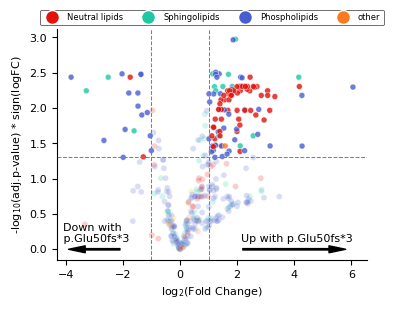

In [419]:
plt.figure(figsize=(4, 3))

temp = lipid_names#[lipid_names['key']=='TG']


temp.loc[(temp['FDR']<0.05) & (np.abs(temp['log2_fold_change'])>1), 'size'] = .8
temp.loc[(temp['FDR']>0.05) | (np.abs(temp['log2_fold_change'])<1), 'size'] = 0.2


sns.scatterplot(data=temp, x='log2_fold_change', y=-1*np.log10(temp['FDR']), hue='Class', size=200, palette=palette, alpha=temp['size'])

sns.despine(top=True, right=True)
plt.xlabel('log$_{2}$(Fold Change)', fontsize=8)
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)', fontsize=8)
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center left')

plt.annotate('', xy=(6,0), xytext=(2, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(4.1, .1, 'Up with p.Glu50fs*3', ha='center', fontsize=8)

plt.annotate('', xy=(-4,0), xytext=(-2, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-3, .1, 'Down with \n p.Glu50fs*3', ha='center', fontsize=8)

#plt.xlim(-3, 3)
plt.legend().remove()
plt.title('', fontsize=8)

labels = ['Neutral lipids', 'Sphingolipids', 'Phospholipids', 'other']

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.1), ncol=4, frameon=True, fontsize=6)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)
# Add vertical line at x=0
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.75)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.75)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.75)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.savefig('../../paper/main_plots/iN_lipids_overview.png', dpi=300, bbox_inches='tight')
plt.show()


In [586]:
lipid_names

3,name,lipidion,key,Class,Subclass,p_value,log2_fold_change,FDR,score,direction,size,cat
name,,,,,,,,,,,,
Cer(d15:0_26:2)-H_47.3,Cer(d15:0_26:2)-H_47.3,Cer(d15:0_26:2)-H,Cer,Sphingolipids,Ceramides,0.096634,-0.612545,0.179414,-0.746145,other,10,other
Cer(d17:1_16:0)-H_42.85,Cer(d17:1_16:0)-H_42.85,Cer(d17:1_16:0)-H,Cer,Sphingolipids,Ceramides,0.524185,-0.242076,0.603607,-0.219246,other,10,other
Cer(d18:0_16:0)+H_35.41,Cer(d18:0_16:0)+H_35.41,Cer(d18:0_16:0)+H,Cer,Sphingolipids,Ceramides,0.407819,0.256591,0.492112,0.307936,other,10,other
Cer(d18:0_18:0)+H_44.03,Cer(d18:0_18:0)+H_44.03,Cer(d18:0_18:0)+H,Cer,Sphingolipids,Ceramides,0.010575,2.109618,0.034345,1.464135,up,10,up
Cer(d18:0_18:0)-H_45.32,Cer(d18:0_18:0)-H_45.32,Cer(d18:0_18:0)-H,Cer,Sphingolipids,Ceramides,0.016795,0.817624,0.046993,1.327963,other,10,up
...,...,...,...,...,...,...,...,...,...,...,...,...
WE(44:4)-H_49.06,WE(44:4)-H_49.06,WE(44:4)-H,WE,Fatty acyl and other lipids,wax esters,0.910982,0.091287,0.940688,0.026554,other,10,other
ZyE()+H-H2O_37.51,ZyE()+H-H2O_37.51,ZyE()+H-H2O,ZyE,Neutral lipids,Zymosterol Ester,0.057955,1.943893,0.129049,0.889245,other,10,other
ZyE(20:3)+H_52.77,ZyE(20:3)+H_52.77,ZyE(20:3)+H,ZyE,Neutral lipids,Zymosterol Ester,0.025413,1.159907,0.063680,1.195994,other,10,other


In [665]:
import pandas as pd
import matplotlib.pyplot as plt

# Example palette mapping lipid categories to colors.
palette = {
    'Cer':'#1DC9A4',
    'Hex1Cer':'#1DC9A4',
    'TG':'#E3120B',
    'MG':'#E3120B',
    'DG':'#E3120B',
    'PC':'#475ED1',
    'LPC':'#475ED1',
    'PS':'#475ED1',

    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids': '#F9C31F', 
    'other': '#F97A1F'
}

# --- Suppose your dataframe is named df and contains a column 'direction' and 'key' ---
# Here we aggregate counts per lipid class:
grouped = lipid_names.groupby('key')['direction'].value_counts().unstack(fill_value=0)

# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)

# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) + grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']
##grouped['empty'] = ''
# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[['up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total', 'empty': ''}
)


In [667]:
import pandas as pd
import matplotlib.pyplot as plt

# Example palette mapping lipid categories to colors.
palette = {
    'Cer':'#1DC9A4',
    'Hex1Cer':'#1DC9A4',
    'TG':'#E3120B',
    'MG':'#E3120B',
    'DG':'#E3120B',
    'PC':'#475ED1',
    'LPC':'#475ED1',
    'PS':'#475ED1',

    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids': '#F9C31F', 
    'other': '#F97A1F'
}

# --- Suppose your dataframe is named df and contains a column 'direction' and 'key' ---
# Here we aggregate counts per lipid class:
grouped = lipid_names.groupby('key')['direction'].value_counts().unstack(fill_value=0)

# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)

# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) + grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']
#grouped['empty'] = ''
# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[[ 'up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total'}
)

# Sort by percentage perturbed in descending order.
table_df = table_df.sort_values(by='Total', ascending=False)
table_df = table_df[table_df['Total']>1]

table_df


direction,Up,Down,Total,% Perturbed
key,,,,
TG,47,0,47,88.7
PC,33,13,46,36.8
Cer,9,3,12,26.7
DG,5,0,5,33.3
Hex1Cer,2,0,2,40.0
PS,1,1,2,9.1
LPC,2,0,2,100.0
MG,0,2,2,66.7


In [595]:
data

direction,,Up,Down,Total,% Perturbed
key,,,,,
TG,,47,0,47,88.7
PC,,33,13,46,36.8
Cer,,9,3,12,26.7
DG,,5,0,5,33.3
Hex1Cer,,2,0,2,40.0
PS,,1,1,2,9.1
LPC,,2,0,2,100.0
MG,,0,2,2,66.7


In [661]:

# Create the DataFrame
data = table_df

df = pd.DataFrame(data)
#df.set_index('key', inplace=True)


In [668]:


# Calculate total number of lipid species for each class
df['Total Species'] = (df['Total'] / (df['% Perturbed'] / 100)).round().astype(int)

# Calculate overall population parameters
N = df['Total Species'].sum()  # Total lipid species in all classes
K = df['Total'].sum()            # Total perturbed lipid species in the population

print(f"Total lipid species (N): {N}")
print(f"Total perturbed species (K): {K}\n")

# Compute hypergeometric p-value for enrichment for each class
# p-value: probability of observing >= k perturbed species in a class by chance.
df['p-value'] = df.apply(
    lambda row: hypergeom.sf(row['Total'] - 1, N, K, row['Total Species']),
    axis=1
)

df = df[[ 'Up', 'Down', 'Total', '% Perturbed', 'p-value']]
# --- Plot the table using matplotlib ---
df['p-value'] = df['p-value'].apply(lambda x: f"{x:.1e}")

df

Total lipid species (N): 270
Total perturbed species (K): 118



/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1786430082.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p-value'] = df['p-value'].apply(lambda x: f"{x:.1e}")


,Up,Down,Total,% Perturbed,p-value
key,,,,,
TG,47,0,47,88.7,4.9e-14
PC,33,13,46,36.8,9.9e-01
Cer,9,3,12,26.7,1.0e+00
DG,5,0,5,33.3,8.7e-01
Hex1Cer,2,0,2,40.0,7.3e-01
PS,1,1,2,9.1,1.0e+00
LPC,2,0,2,100.0,1.9e-01
MG,0,2,2,66.7,4.1e-01


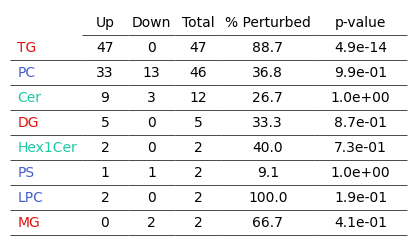

In [671]:
i
import pandas as pd
from scipy.stats import hypergeom

#df.columns = ['', 'Up', 'Down', 'Total', '% Perturbed', 'p-value']
table_df = df
fig, ax = plt.subplots(figsize=(3,2))
ax.axis('off')  # Hide the main axes

tbl = ax.table(cellText=table_df.values,
               rowLabels=table_df.index,
               colLabels=table_df.columns,
               cellLoc='center',
               loc='center', colWidths=[0.2, 0.2, 0.2, 0.4, 0.4])

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Color the row labels according to the palette.
# Matplotlib stores row labels in cells with (row, col) where col == -1.
for (row, col), cell in tbl.get_celld().items():
    if col == 0 and row > 0:  # row>0: skip header row label cell
        lipid_class = table_df.index[row-1]  # row labels start at row 1 in the table cells
        #print(lipid_class)
        # If the lipid class directly matches a key in your palette, use that;
        # otherwise, you can map it to a category. Here we assume they match.
        cell.set_facecolor(palette.get(lipid_class, 'blue'))

for key, cell in tbl.get_celld().items():
    
        cell.set_edgecolor('white')

for (row, col), cell in tbl.get_celld().items():
    if row > 0:  # for all cells in data rows
        # Show only the bottom edge:
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
    else:
        # For header row, you can keep the default (or set a full box if desired)
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)

    if col == -1 and row > 0:  # skip header label cell if present
        lipid_class = df.index[row-1]  # adjust index for header offset
        cell.get_text().set_color(palette.get(lipid_class, 'black'))


plt.savefig('../../paper/main_plots/lipids_table.png', dpi=300, bbox_inches='tight')

#ax.set_title("Perturbation Summary by Lipid Class", fontweight="bold", pad=20)
plt.show()


In [797]:
# then show PCs and TGs volcano , saturation and length

temp = lipid_names[lipid_names['key']=='TG']
temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)
temp['type'] = (temp['total_carbons']/3).apply(lambda x: 'Short-Chain' if x < 6 else ('Medium-Chain' if x < 13 else ('Long-Chain' if x < 22 else 'Very-Long-Chain')))
temp['score'] = np.sign(temp['log2_fold_change'])*-np.log10(temp['FDR'])

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/496395372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/496395372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/496395372.py:6: SettingWithCopyWarning: 
A value is trying to b

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


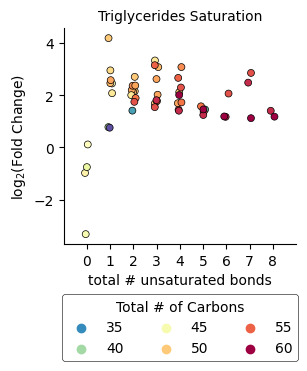

In [805]:
plt.figure(figsize=(3, 2.8))
#ax = sns.boxplot(data=temp, x='double_bonds', y='log2_fold_change', color = 'white', width= 0.4, showfliers=False, linewidth=1, 
                 #boxprops=dict(edgecolor='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'))#, hue = 'log2_fold_change')
sp = sns.stripplot(data=temp, x='double_bonds', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'total_carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

# shift = 0.4  # Adjust this value as needed
# for i, coll in enumerate(sp.collections):
#         # if i == 0:
#         #     shift = 0.4
#         # elif i == 1:
#         #     shift = 0.4
#         # elif i == 2:
#         #     shift = 0.4
            
#         offsets = coll.get_offsets()
#         # Subtract from the x-coordinate to move left
#         offsets[:, 0] = offsets[:, 0] + shift
#         coll.set_offsets(offsets)

legend = plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3, frameon=True, title='Total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # unsaturated bonds', fontsize=10)
plt.title('Triglycerides Saturation', fontsize=10)

plt.xlim(-1,9)
plt.savefig('../../paper/main_plots/tg_saturation.png', dpi=300, bbox_inches='tight')


In [806]:
# then show PCs and TGs volcano , saturation and length

temp = lipid_names[lipid_names['key']=='PC']
temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)
temp['type'] = (temp['total_carbons']/3).apply(lambda x: 'Short-Chain' if x < 6 else ('Medium-Chain' if x < 13 else ('Long-Chain' if x < 22 else 'Very-Long-Chain')))
temp['score'] = np.sign(temp['log2_fold_change'])*-np.log10(temp['FDR'])

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1422215809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['double_bonds'] = temp['lipidion'].apply(sum_double_bonds)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1422215809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['total_carbons'] = temp['lipidion'].apply(sum_total_carbons)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_67644/1422215809.py:6: SettingWithCopyWarning: 
A value is trying t

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


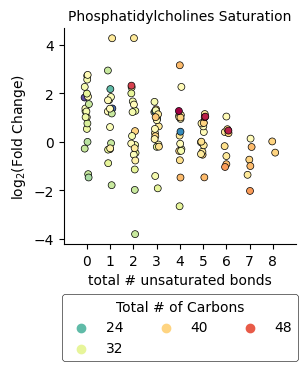

In [808]:
plt.figure(figsize=(3, 2.8))
#ax = sns.boxplot(data=temp, x='double_bonds', y='log2_fold_change', color = 'white', width= 0.4, showfliers=False, linewidth=1, 
                 #boxprops=dict(edgecolor='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='black'))#, hue = 'log2_fold_change')
sp = sns.stripplot(data=temp, x='double_bonds', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'total_carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

# shift = 0.4  # Adjust this value as needed
# for i, coll in enumerate(sp.collections):
#         # if i == 0:
#         #     shift = 0.4
#         # elif i == 1:
#         #     shift = 0.4
#         # elif i == 2:
#         #     shift = 0.4
            
#         offsets = coll.get_offsets()
#         # Subtract from the x-coordinate to move left
#         offsets[:, 0] = offsets[:, 0] + shift
#         coll.set_offsets(offsets)

legend = plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3, frameon=True, title='Total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # unsaturated bonds', fontsize=10)
plt.title('Phosphatidylcholines Saturation', fontsize=10)

plt.xlim(-1,9)
plt.savefig('../../paper/main_plots/pc_saturation.png', dpi=300, bbox_inches='tight')
